In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [2]:
import models.graphene_thermodynamics_v2 as gt
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG

In [3]:
# Load interpolation data for the calculation of chemical potentials.
mm = gt.mu_func_use_2d_interpolation(load_from="mu_table.pkl")

# Run evolutions at variable Fermi energy and delay

In [4]:
run_label = "recover"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/04/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

In [5]:
# One time-evolution with pump and probe pulse.
def oneRun(x):
    dyn = CoolingPhonons(**x["sysparams"])
    # Integrate up to a bit later than the end of the probe pulse.
    tmax = x["sysparams"]["pr_delay"] + x["sysparams"]["pr_dt"] * 2.0
    runparams = {
        "tmax": tmax,
        "tnum": np.maximum(50, int(300 * tmax / 1.0e+4)),  # proportional to 300 points for 10ps
        "dt_approx": 10.0,
        "print_time": False    
    }
    dyn.run(**runparams)

    # -- save data snippets -- filename labels not correct!
    # with open("%s/params-%02d.json" % (x["saveDir"], x["il"]), "w") as f:
    #     json.dump({"sysparams": x["sysparams"], "runparams": runparams}, f, indent=4)    

    # Save the THG in time during the pulse.
    if x["saveTHG"]:
        np.savetxt("%s/thg-%s.csv" % (x["saveDir"], x["label"]), np.c_[dyn.p["pr_tt"],dyn.p["etaTHG"]], delimiter=",")
        np.savetxt("%s/dynamics-%s.csv" % (x["saveDir"], x["label"]), dyn.dynamics_m, delimiter=",")
    
    with open("%s/thg_data-%s.json" % (x["saveDir"], x["label"]), "w") as f:
        json.dump(dyn.p["thg_data"], f)
    
    r = (x["i_eF"], x["i_delay"], dyn.p["etaTHG_avg"])
    # np.savetxt("%s/thg_avg-%02d.csv" % (x["saveDir"], x["il"]), np.array(r), delimiter=",")
    return r

In [6]:
# Constant parameters of the functional dependence of the parameter Gamma
# (i.e. the single-electron scattering rate in the THG formula)
# Gamma = (a + c k_B * T_L) * e_F + b / e_F
# Obtained by a fit of no-pump measures, see notebooks 07x.
gammaParams = {
    "a": 0.704531,
    "b": 0.007437,
    "c": 0.001507
}

# Generate a list of parameters to parallelize the calculation.
sysparams = {
    "tempK_eq": 30.0,
    "tau_ph": 1200.0,
    "pu_fluenceSI": 20.0,  # ORIG: 200.0
    "pu_dt": 110.0,
    "pu_eph": 1.200,
    "pr_fluenceSI": 11.0,  # ORIG: 110.0
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,  # hBN encapsulated with SiO2 around
    "ntop": 1.4,
    "alpha_res": 1.0e-3,  # ORIG: 1.0e-3
    "dtdb": 45.0,  # ORIG: 200.0
    "ph_en_frac": 1.0,
    "dtdb_cutoff_dens": None,
    "pe_relax_rate": 1.0/10.0
}

# Specific values of Gamma.
sysparams["gammaConst"] = 0.0
sysparams["gammaInv"] = gammaParams["b"]
sysparams["gammaProp"] = gammaParams["a"] + gammaParams["c"] * sysparams["tempK_eq"] / 11600.0


# List of delay values.
pr_delay_list = np.linspace(20.0, 300.0, 21)
# List of Fermi energies.
eF_list = np.linspace(0.050, 0.350, 31)

# Add the value of the delay, taken from the list, to the dictionary of sysparams.
params_list = []
for i_eF,eF in enumerate(eF_list):
    for i_delay,pr_delay in enumerate(pr_delay_list):
        params_list.append({"i_eF": i_eF, "i_delay": i_delay, "saveDir": saveDir, "label": ("%02d-%02d" % (i_eF, i_delay)),
                            "saveTHG": False, "sysparams": {**sysparams, "eF": eF, "pr_delay": pr_delay}})

# Parameters to calculate the THG without the pump pulse, i.e. with negligible intensity.
sysparams0 = sysparams.copy()
sysparams0["pu_fluenceSI"] = 0.0  # zero pump fluence
sysparams0["pr_delay"] = pr_delay_list[0]  # just one fixed delay

params0_list = []
for i_eF,eF in enumerate(eF_list):
    params0_list.append({"i_eF": i_eF, "i_delay": 0, "saveDir": saveDir, "label": ("%02d" % i_eF),
                         "saveTHG": True, "sysparams": {**sysparams0, "eF": eF}})


In [7]:
# Run the calculation.
with mp.Pool(24) as p:
    thg_list = p.map(oneRun, params_list)

with mp.Pool(24) as p:
    thg0_list = p.map(oneRun, params0_list)

In [8]:
# Copy the (possibly un-ordered) lists of results to dataframes.
thg_df = np.zeros((len(eF_list),len(pr_delay_list)))
thg0_df = np.zeros((len(eF_list),1))

for r in thg_list:
    thg_df[r[0],r[1]] = r[2]
for r in thg0_list:
    thg0_df[r[0],r[1]] = r[2]

# Save results.
with open("%s/params.json" % saveDir, "w") as f:
    json.dump(sysparams, f, indent=4)
np.savetxt("%s/delay_list.csv" % saveDir, pr_delay_list, delimiter=",")
np.savetxt("%s/eF_list.csv" % saveDir, eF_list, delimiter=",")
np.savetxt("%s/thg_eF_delay.csv" % saveDir, thg_df, delimiter=",")
np.savetxt("%s/thg0_eF.csv" % saveDir, thg0_df, delimiter=",")

# Analyze runs to calculate the differential THG

In [9]:
# If might be necessary to reload data for plotting or analysis.
if False:
    saveDir = "./data/04/2023-05-20-01-12-26_scan_fermi"
    pr_delay_list = np.loadtxt("%s/delay_list.csv" % saveDir, delimiter=",")
    eF_list = np.loadtxt("%s/eF_list.csv" % saveDir, delimiter=",")
    thg_df = np.loadtxt("%s/thg_eF_delay.csv" % saveDir, delimiter=",")
    thg0_df = np.loadtxt("%s/thg0_eF.csv" % saveDir, delimiter=",", ndmin=2)

In [10]:
# For each Fermi energy, find the signal minimum as the delay varies.
signal_min = np.array([thg.min() for thg in thg_df])
np.savetxt("%s/signal_min.csv" % saveDir, np.c_[eF_list,signal_min], delimiter=",")

# For each Fermi energy, calculate the "differential" THG as the delay varies.
dthg_df = (thg_df - thg0_df) / thg0_df

# For each Fermi energy, find the minimum of the differential THG.
# This is by definition the modulation of the THG.
modulation = np.array([dthg.min() for dthg in dthg_df])
np.savetxt("%s/modulation.csv" % saveDir, np.c_[eF_list,modulation], delimiter=",")

# For each Fermi energy, evaluate the differential THG at a given delay.
# Compare this definition of modulation with the previous one.
t0 = 150.0
it0 = np.argmin(np.abs(pr_delay_list - t0))
modulation_fixdel = np.array([dthg[it0] for dthg in dthg_df])


# Plot results

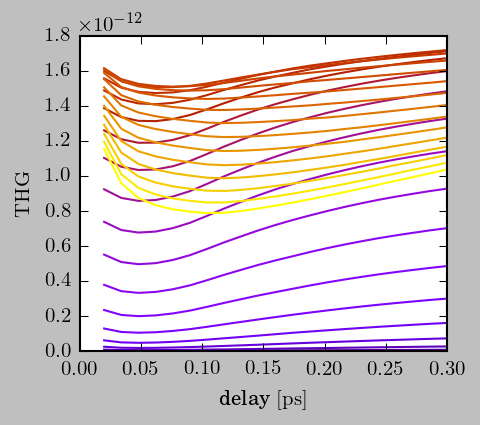

In [11]:
# Plot the THG as a function of delay for all the Fermi energies.
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap("gnuplot")
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for ic,ithg in enumerate(thg_df):
    plt.plot(pr_delay_list * 1.0e-3, ithg, "-", ms=3.0, color=cmap(ic/(len(thg_df)-1.0)) )
#plt.xlim([0.0, 1.0])
#plt.ylim([-1.0, 0.0])
plt.xlabel(r"delay $[{\rm ps}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.ylabel(r"${\rm THG}$")
plt.savefig("%s/plot_THG_delay.png" % saveDir, dpi=300)

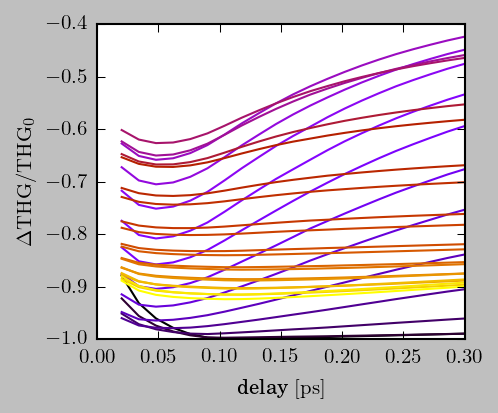

In [12]:
# Plot the differential THG as a function of delay for all the Fermi energies.
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap("gnuplot")
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for ic,ithg in enumerate(dthg_df):
    plt.plot(pr_delay_list * 1.0e-3, ithg, "-", ms=3.0, color=cmap(ic/(len(thg_df)-1.0)) )
#plt.xlim([0.0, 1.0])
#plt.ylim([-1.0, 0.0])
plt.xlabel(r"delay $[{\rm ps}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.ylabel(r"$\Delta{\rm THG}/{\rm THG}_{0}$")
plt.savefig("%s/plot_DTHG_delay.png" % saveDir, dpi=300)

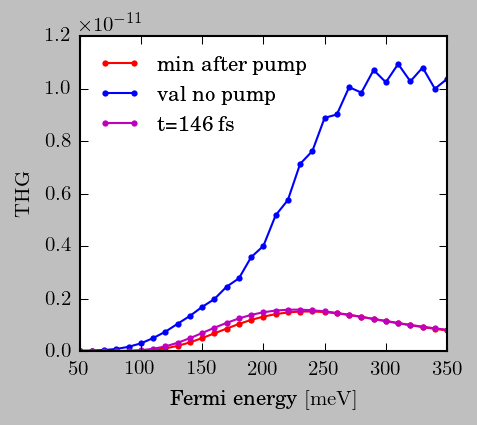

In [15]:
# Plot the signal minimum and the signal without the pump
# as a function of the Fermi energy.
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(eF_list * 1.0e+3, signal_min, "-or", ms=3.0, mew=0, label="min after pump")
plt.plot(eF_list * 1.0e+3, thg0_df[:,0], "-ob", ms=3.0, mew=0, label="val no pump")
plt.plot(eF_list * 1.0e+3, thg_df[:,it0], "-om", ms=3.0, mew=0, label=r"t=%.0f~{\rm fs}" % pr_delay_list[it0])
#plt.xlim([0.0, 1.0])
#plt.ylim([-1.0, 0.0])
plt.xlabel(r"Fermi energy $[{\rm meV}]$")
plt.ylabel(r"${\rm THG}$")
plt.legend(frameon=False, loc="upper left")
plt.savefig("%s/plot_THGmin_eF.png" % saveDir, dpi=300)

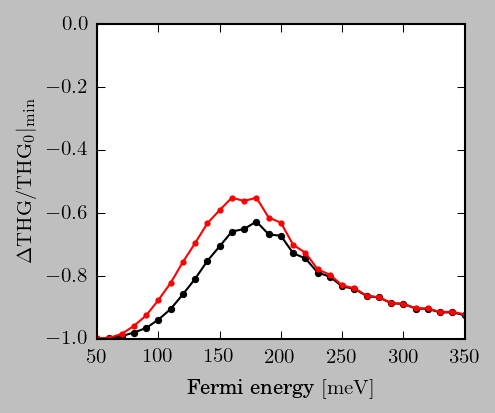

In [14]:
# Plot the modulation as a function of the Fermi energy.
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(eF_list * 1.0e+3, modulation, "-ok", ms=3.0)
plt.plot(eF_list * 1.0e+3, modulation_fixdel, "-or", mew=0, ms=3.0)
#plt.xlim([0.0, 1.0])
plt.ylim([-1.0, 0.0])
plt.xlabel(r"Fermi energy $[{\rm meV}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.ylabel(r"$\Delta{\rm THG}/{\rm THG}_{0}\vert_{\rm min}$")
plt.savefig("%s/plot_modulation_eF.png" % saveDir, dpi=300)

# Plot THG in time without the pump

In [ ]:
# This is aimed at solving a problem where the THG oscillates as the
# Fermi energy is changed, for the runs without the pump.

In [ ]:
dynamics_list = []
for i_eF,eF in enumerate(eF_list):
    dynamics_list.append(np.loadtxt("%s/dynamics-%02d.csv" % (saveDir, i_eF), delimiter=","))

In [ ]:
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap("gnuplot")
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.axvspan(sysparams0["pr_delay"], (sysparams0["pr_delay"] + sysparams0["pr_dt"]), color="lightskyblue")
for ic,dyn in enumerate(dynamics_list):
    # Order of the columns:
    # tt, tempK_t, muC_t, muV_t, dnE_t, nG_t, nK_t, enmax_t
    plt.plot(dyn[:,0], dyn[:,4], "-", ms=3.0, color=cmap(ic/(len(dynamics_list)-1.0)) )
# plt.xlim([sysparams0["pr_delay"], sysparams0["pr_delay"]+sysparams0["pr_dt"]])
#plt.ylim([-1.0, 0.0])
plt.xlabel(r"$t~[{\rm fs}]$")

In [ ]:
thg_tt_list = []
for i_eF,eF in enumerate(eF_list):
    thg_tt_list.append(np.loadtxt("%s/thg-%02d.csv" % (saveDir, i_eF), delimiter=","))

In [ ]:
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap("gnuplot")
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for ic,thg_tt in enumerate(thg_tt_list):
    plt.plot(thg_tt[:,0], np.log10(thg_tt[:,1]), "-", ms=3.0, color=cmap(ic/(len(thg_tt_list)-1.0)) )
plt.xlim([sysparams0["pr_delay"], sysparams0["pr_delay"]+sysparams0["pr_dt"]])
#plt.ylim([-1.0, 0.0])
plt.xlabel(r"$t~[{\rm fs}]$")